In [595]:
import pandas as pd
import os
import random 
import seaborn as sns


from mcr_const.constraints.nist import ConstraintPointBelow
from pymcr.mcr import McrAR
from pymcr.regressors import NNLS, OLS
from pymcr.constraints import ConstraintNorm
import pymcr
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable, Function
import itertools

import argparse
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset # this is a class import (base for later custom class)
from torchvision.transforms import transforms

# sends tensor operations to GPU if available (can also be individually specified)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('You are using a {} device.'.format(device))

cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


You are using a cpu device.


### input section for user-defined args here ##########

In [596]:
dataframe = pd.read_csv('mcr_data/spectra_4_sequence.csv', header = None, delimiter = '\t')
data = torch.tensor(dataframe.to_numpy())

############# PARAMETERS ##############
# the following assumes that the spectral sequence is imported row-by-row, as is typical of csv files

n_rows = data.shape[0]
n_pixels = data.shape[1]
print('Number of spectra in sequence: {} \nNumber of points per spectra: {}'.format(n_rows, n_pixels))

####### FUTURE EDITS - USER-DEFINED PARAMETERS #######
n_comps = 4   
b1 = 0.5
runs = 100
b2 = 0.999
latent_dim = 2
interface = [19, 37]

############## change linear dim to be variables so it works with each of these ################
#### concentration : n_rows x n_comps
#### spectra : n_pixels x n_comps


Number of spectra in sequence: 60 
Number of points per spectra: 250


In [597]:
############# PARAMETERS ##############
# the following assumes that the spectral sequence is imported row-by-row, as is typical of csv files
spectra_sequence = torch.tensor(data.clone().detach(), dtype = torch.float32)

n_rows = spectra_sequence.shape[0]
n_pixels = spectra_sequence.shape[1]
shape = (n_rows, n_pixels)
sliceval = spectra_sequence.shape[0] // n_comps   

print('Number of spectra in sequence: {} \nNumber of points per spectra: {}'.format(n_rows, n_pixels))

####### FUTURE EDITS - USER-DEFINED PARAMETERS #######
n_comps = 4
b1 = 0.5
b2 = 0.999

sequence_length = n_rows
       

Number of spectra in sequence: 60 
Number of points per spectra: 250


/tmp/ipykernel_70/46858297.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectra_sequence = torch.tensor(data.clone().detach(), dtype = torch.float32)


Max iterations reached (50).
Max iterations reached (100).


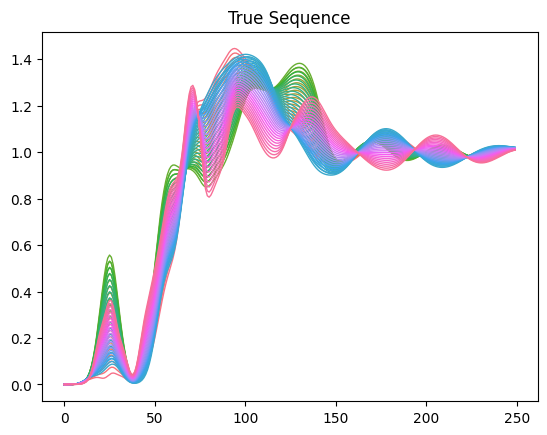

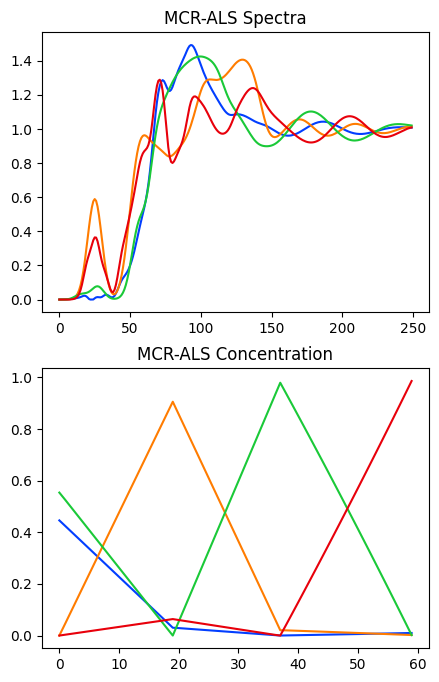

In [598]:
###################################################################
##### GENERATING INITIAL GUESS FOR SPECTRA AND CONCENTRATION ######
###################################################################

spec, multvals = [], []
#averaging slices based upon user-input number of chemical components in the sample 
for i in range(n_comps): 
    val = torch.tensor(((dataframe.iloc[sliceval*i : sliceval*(i+1)].mean(axis=0))))
   # val = data[sliceval*i : sliceval*(i+1)].mean(axis=0)
    spec.append(val)
sns.set_palette('husl', 60)
specguess = spectra_sequence[[5, 20, 40, -3]]

## VISUALIZATION ##
plt.figure()
for i in data: 
    plt.plot(i, lw = 1.0)
    plt.title('True Sequence')
plt.savefig("true_sequence.svg", format="svg")
mcrar = McrAR(max_iter = 50, c_regr=NNLS(), st_regr=NNLS(), c_constraints = [ConstraintNorm()])
mcrar.fit(data, ST = specguess)
resolved_conc = mcrar.C_opt_
resolved_spec = mcrar.ST_opt_
resolved_seq = mcrar.D_opt_

rank_selectivity = ConstraintPointBelow.from_phase_law(
    n_species=4,
    sequence_length=spectra_sequence.shape[0],
    interface_positions=[19, 37],
    threshold=1.0E-5)
mcrar = McrAR(max_iter = 100, c_regr=NNLS(), st_regr=NNLS(), c_constraints = [ConstraintNorm(), rank_selectivity])
mcrar.fit(data, ST = specguess)
resolved_conc_rank = mcrar.C_opt_
resolved_spec_rank = mcrar.ST_opt_
sns.set_palette('bright', 4)

fig, ax = plt.subplots(2, 1, figsize = (5, 8))
ax[0].set_title('MCR-ALS Spectra')
ax[1].plot(resolved_conc)
ax[1].set_title('MCR-ALS Concentration')
ax[0].plot(resolved_spec.T)
plt.savefig("mcr_als_results.svg", format="svg")

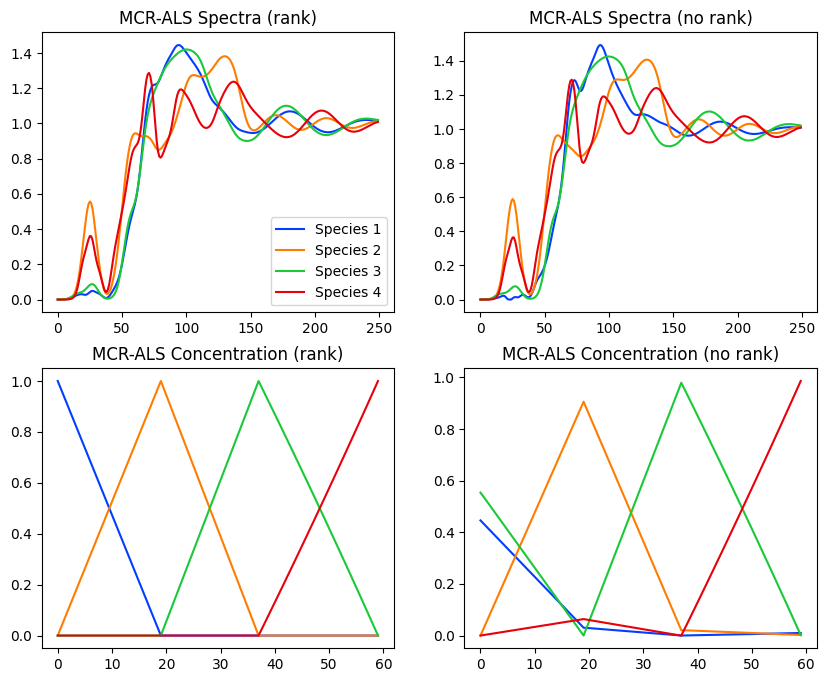

In [599]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 8))
labels = []
for i in range(1, 5): 
    labels.append('Species {}'.format(i))
    
ax1.plot(resolved_spec_rank.T)
ax1.legend(labels)
ax1.set_title('MCR-ALS Spectra (rank)')
ax3.plot(resolved_conc_rank)
ax3.set_title('MCR-ALS Concentration (rank)')
ax2.plot(resolved_spec.T)
ax2.set_title('MCR-ALS Spectra (no rank)')
ax4.plot(resolved_conc)
ax4.set_title('MCR-ALS Concentration (no rank)')
plt.savefig("mcr_als_results.svg", format="svg")

# Neural Network - Decoder + Discriminator for Generating Sequence

In [600]:
class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, beta):
        ctx.beta = beta
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        if ctx.beta is not None:
            grad_input = -grad_input * ctx.beta
        return grad_input, None

In [601]:
class Reconstruction(nn.Module): 
    def __init__(self): 
        super(Reconstruction, self).__init__()
    def forward(self, conc, spec): 
        val = (conc[:,:,:,np.newaxis]@spec[:, :, np.newaxis, :]).sum(axis = 1)
        return val
        
reconstruct = Reconstruction()

In [602]:
class DiscriminatorSpec(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pixels*n_comps, 5*runs),    #### input, output
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(5*runs, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 100), 
            nn.Dropout(0.1),        # randomly zeroes out some values during training with probability p (passed arg)
            nn.Linear(100, latent_dim), 
          #  nn.Sigmoid(),
    )
        
    def forward(self, x, beta):
        x = GradientReversalLayer.apply(x, beta)
        x = x.view(x.shape[0], -1)
        validity = self.model(x)
        return validity.float()
    
discriminator_spec = DiscriminatorSpec()    # instantiate class

print(discriminator_spec)


DiscriminatorSpec(
  (model): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=500, out_features=300, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=300, out_features=100, bias=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [603]:
# Discriminator - takes input from encoder and tests validity - binary classifier (sigmoid)
class DiscriminatorConc(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(  
            nn.Linear(n_rows * n_comps, runs),    #### input, output
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(runs, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.1), 
            nn.Linear(50, latent_dim), 
           # nn.Sigmoid(),   
    )
        
    def forward(self, x, beta): 
        x = GradientReversalLayer.apply(x, beta)
        x = x.view(x.shape[0], -1)
        validity = self.model(x)
        return validity.float()
    
discriminator_conc = DiscriminatorConc()    # instantiate class
print(discriminator_conc)

DiscriminatorConc(
  (model): Sequential(
    (0): Linear(in_features=240, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)


# Full Range XANES

In [808]:
runs = 100
epochs = 300
MSElist, d_loss_spec, d_loss_conc = [], [], []
BCE = nn.BCEWithLogitsLoss()
MSE = nn.MSELoss()

###### one of either rank or no rank (not both)
spec = torch.tensor(resolved_spec[np.newaxis, :, :] + 
        0.2*np.random.rand(runs,  *resolved_spec.shape), requires_grad = True, dtype = torch.float32)
conc = torch.tensor(resolved_conc.T[np.newaxis, :, :] + 
        0.2*np.random.rand(runs, *resolved_conc.T.shape), requires_grad = True, dtype = torch.float32)

true_seq = torch.tensor(spectra_sequence[np.newaxis, :, :] + 0*np.random.rand(runs,  *spectra_sequence.shape), requires_grad = True, dtype = torch.float32)
valid = Variable(Tensor(runs, latent_dim).fill_(1.0), requires_grad=False)
fake = Variable(Tensor(runs, latent_dim).fill_(0.0), requires_grad=False)

recon_opt = optim.Adam([conc, spec], lr = 0.01)
discriminator_opt_c = optim.Adam(discriminator_conc.parameters(), lr = 0.1)
discriminator_opt_s = optim.Adam(discriminator_spec.parameters(), lr = 0.1)

/tmp/ipykernel_70/3805010671.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_seq = torch.tensor(spectra_sequence[np.newaxis, :, :] + 0*np.random.rand(runs,  *spectra_sequence.shape), requires_grad = True, dtype = torch.float32)


In [809]:
zero_positions = [np.r_[0:pre, post:sequence_length] 
                              for pre, post in zip([0, 0] + interface, interface + [sequence_length, sequence_length])]
zero_indices = [(zp, np.full_like(zp, fill_value=i)) for i, zp in enumerate(zero_positions)]

do_rank = False
do_const == True     ### activate/deactivate all constraints
stds = []
alpha = 3
for epoch in range(epochs):  
            recon_opt.zero_grad()
                
        ### Non-negative constraint - Spectra (ST) and Concentration (C) ###    
            spec_neg_vals = spec[spec<0]
            non_neg_spec_loss = MSE(spec_neg_vals, torch.zeros_like(spec_neg_vals, requires_grad = False))
            
            conc_neg_vals = conc[conc<0]
            non_neg_conc_loss = MSE(conc_neg_vals, torch.zeros_like(conc_neg_vals, requires_grad = False))
   
         ### Normalization constraint - Concentration (C) ###
            if do_const == True: 
                maxout_conc = conc[conc>1]
                conc_norm_to_one_loss = MSE(maxout_conc, torch.ones_like(maxout_conc, requires_grad = False))
                conc_sum = conc.clone().sum(axis = 1)
                conc_add_to_one_loss = MSE(conc_sum, torch.ones_like(conc_sum, requires_grad = False))
            
            if do_rank == True: 
                conc_copy = torch.transpose(conc.clone(), 1, 2)
                prev_mean = conc_copy.mean()
                for p in zero_indices: 
                    for x in range(runs):
                        if (conc_copy[x][p].any() > 1.0e-3):
                            conc_copy[x][p] = 1.0e-3  
                conc_copy *= prev_mean/conc_copy.mean()
            
        ### Backprop ###
            if do_rank == True: 
                rank_loss = MSE(conc, torch.transpose(conc_copy, 1, 2))
                rank_loss.backward()
            if do_const == True: 
                conc_norm_to_one_loss.backward()
                conc_add_to_one_loss.backward()     
                
            lossMSE = MSE(reconstruct(conc, spec), true_seq)
                    #
                ### reconstruction loss
            lossMSE.backward()
            non_neg_spec_loss.backward()
            non_neg_conc_loss.backward()
            recon_opt.step()
            
              #### Adversarial  Loss #####
            discriminator_opt_s.zero_grad()
            real_loss_spec = BCE(discriminator_spec(torch.randn(runs, n_pixels*n_comps, requires_grad = True), alpha), valid)
            fake_loss_spec = BCE(discriminator_spec((spec-spec.mean(axis = 0)[np.newaxis,...])/spec.std(axis = 0)[np.newaxis,...], alpha), fake)
            discriminator_loss_spec = (fake_loss_spec + real_loss_spec)/2
            discriminator_loss_spec.backward()
            discriminator_opt_s.step()
            #############################
            discriminator_opt_c.zero_grad()
            real_loss_conc = BCE(discriminator_conc(torch.randn(runs, n_rows*n_comps, requires_grad = True), alpha), valid)
            fake_loss_conc = BCE(discriminator_conc((conc-conc.mean(axis = 0)[np.newaxis,...])/conc.std(axis = 0)[np.newaxis,...], alpha), fake)
            discriminator_loss_conc = (fake_loss_conc + real_loss_conc)/2
            discriminator_loss_conc.backward()
            discriminator_opt_c.step()     
            
            ######## INFORMATION #########
            if epoch%100 == 0: 
                print("[Epoch %d/%d] [Reconstruction loss: %f]"% (epoch, epochs, lossMSE.item()))
             #############################

            #############################
            d_loss_spec.append(discriminator_loss_spec.item())
            d_loss_conc.append(discriminator_loss_conc.item())
            MSElist.append(lossMSE.item())
            
print('\n . . . Finished  . . . \n')


[Epoch 0/300] [Reconstruction loss: 0.270280]
[Epoch 100/300] [Reconstruction loss: 0.000102]
[Epoch 200/300] [Reconstruction loss: 0.000041]

 . . . Finished  . . . 



# BREAK

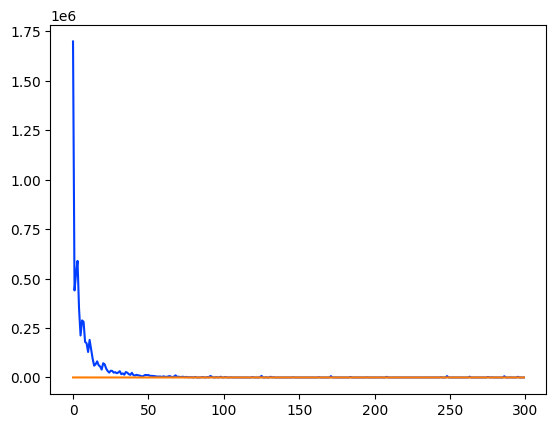

In [810]:
solc = conc
sols = spec
#plt.plot(MSElist)
plt.plot(d_loss_spec)
plt.plot(d_loss_conc)

In [879]:
stdev_conc = np.std(solc.clone().detach().numpy(), axis = 0)
stdev_spec = np.std(sols.clone().detach().numpy(), axis = 0)

avg_spec = torch.sum(sols.clone().detach(), dim = 0)/(solc.shape[0])
avg_conc = torch.sum(solc.clone().detach(), dim = 0)/(solc.shape[0])

conc_x = np.arange(1, n_rows+1)
spec_x = np.arange(1, n_pixels+1)

sns.set_palette('bright', 4)

labels = []
for i in range(1, 5): 
    labels.append('Species {}'.format(i))

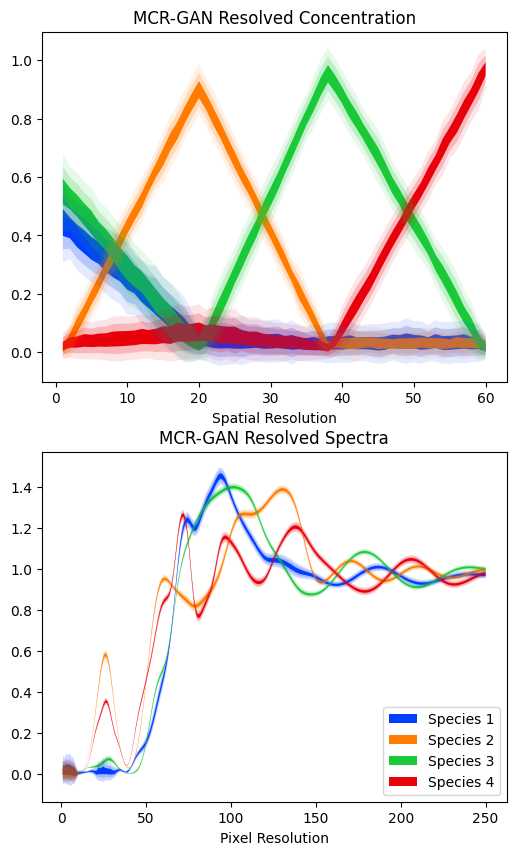

In [890]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))

for i in range(4): 
    low1 = avg_conc[i] - stdev_conc
    high1 = avg_conc[i] + stdev_conc
    ax[0].fill_between(conc_x, low1.numpy()[i], high1.detach()[i], alpha = 1)
    
    low1 = avg_spec[i] - stdev_spec
    high1 = avg_spec[i] + stdev_spec
    ax[1].fill_between(spec_x, low1.detach().numpy()[i], high1.detach().numpy()[i], alpha = 1)
    
for i in range(4): 
    low2 = avg_conc[i] - 2*stdev_conc
    high2 = avg_conc[i] + 2*stdev_conc
    ax[0].fill_between(conc_x, low2.numpy()[i], high2.detach()[i], alpha = 0.2)
    
    low2 = avg_spec[i] - 2*stdev_spec
    high2 = avg_spec[i] + 2*stdev_spec
    ax[1].fill_between(spec_x, low2.detach().numpy()[i], high2.detach().numpy()[i], alpha = 0.2)
    ax[1].legend(labels, loc = 'lower right')

    
for i in range(4): 
    low3 = avg_conc[i] - 3*stdev_conc
    high3 = avg_conc[i] + 3*stdev_conc
    ax[0].fill_between(conc_x, low3.numpy()[i], high3.detach()[i], alpha = 0.1)
   # ax[0].plot(conc_x, avg_conc[i])  
    
    low3 = avg_spec[i] - 3*stdev_spec
    high3 = avg_spec[i] + 3*stdev_spec
    ax[1].fill_between(spec_x, low3.detach().numpy()[i], high3.detach().numpy()[i], alpha = 0.2)
    #ax[1].plot(spec_x, avg_spec[i])
    ax[1].legend(labels, loc = 'lower right')
    
ax[0].set_title('MCR-GAN Resolved Concentration')
ax[0].set_xlabel('Spatial Resolution')
ax[1].set_title('MCR-GAN Resolved Spectra')
ax[1].set_xlabel('Pixel Resolution')
if do_rank == True: 
    plt.savefig("MCR_GAN_true.svg", format="svg")
else: 
    plt.savefig("MCR_GAN_false.svg", format="svg")